# PDF Regression

In this tutorial we are going to utilize and expand on what you learned yesterday in the regression example.
We are going to apply the same techniques to the problem of PDF fitting.

#### In this tutorial

We start by fitting a known PDF (as given by LHAPDF) for a fixed scale.
We start with a naive neural network (although already tuned to our problem) to get an approximation of the pdf itself.

Then we will apply some physical constraints to the result for which we cannot use the ready-made ML tools given by `tensorflow`.
And we will preprocess the input to avoid saturation due to the different scales of the input.

Finally we will complicate a bit more the fit by adding fitting all partons at the same time.

In [1]:
# This is a suggestion of imports that might be useful for this tutorial

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential

tf.keras.backend.clear_session()

# We will use LHAPDF as a source of data, so you will need this:
from lhapdf import mkPDF

## Fitting a PDF

We are going to use the `lhapdf` library ant the `NNPDF40_nnlo_as_01180` PDF set. We start by reading a large number of points that we will use to train the network later on.

### Reading the data

In [2]:
pdf_set = "NNPDF40_nnlo_as_01180"
pdf_target = mkPDF(pdf_set)

q0 = 1.65  # Reference scale
npoints = int(5e4)  # How many points to use for training

xgrid = np.concatenate([np.logspace(-5, -1, npoints // 2), np.linspace(0.1, 1, npoints // 2)])
pdf_grid_all = pdf_target.xfxQ2(xgrid, np.ones_like(xgrid) * q0**2)

LHAPDF 6.5.3 loading /opt/homebrew/Cellar/lhapdf/6.5.3/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


### 0. Plot some PDFs to see how they look

Code suggestion:

```python
flavour_select = [21, 1, 2, -2]
pdf_grid = {i:[] for i in flavour_select}

for point in pdf_grid_all[::200]:
    for pid in flavour_select:
        pdf_grid[pid].append(point[pid])

fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
fig.suptitle(f"PDF plots for {pdf_set}, Q = {q0}")
for i, (parton, val) in enumerate(pdf_grid.items()):
    plt.subplot(2, 2, i + 1)

    plt.plot(xgrid[::200], val, label=f"${parton}$")
    plt.legend()
    plt.xscale("log")
    if i > 1:
        plt.xlabel("x")
    plt.ylabel(f"$x_{{{parton}}}(x)$")
```

### 1. Fit a Neural Network PDF: NN PDF

1. Create a model that takes 1 value as input (`x`) and outputs 1 value (the PDF at that value of x, f(x)). A suggestion would be a perceptron with ~3 layers, ~16 hidden units per layer

2. Write a plotting function so that we can easily compare the output of our model to the actual values, use it with your untrained model to see how (bad!) the results are

3. Perform a fit for a choosen PDF flavour

4. Perform the same comparison as point 2 with the trained PDF!

code suggestion:
```python
    # Model - PDF comparison
    def compare_model(model, ivals, fval, label=name, scale="linear"):
        """Compare the result of a model for a PDF with the target result"""
        vals = model(ivals)

        plt.plot(ivals, vals, label="NN")
        plt.plot(ivals, fval, label=label)
        plt.legend()
        plt.xlabel("x")
        plt.ylabel(rf"$x{name}(x, Q_{0})$")
        plt.xscale(scale)
                   
    # Get data for a single flavour and prepare for training the ML model
    target_pid = 21
    parton_data = np.array([pdf_grid[target_pid] for pdf_grid in pdf_grid_all])
    # The tensorflow model expects the input to be (ndim, batch_size) in our case ndim = 1 (x)
    input_xgrid = xgrid.reshape(-1, 1)
```

### 2. Physical motivation: output processing

While it is possible that the results of the Neural Networks are already quite good, they might not be physically sound.

Check what happens when we close to x->1.0

```python
    print(f"PDF result for f(x=1.0) = {pdf_target.xfxQ2(target_pid, 1.0, q0**2):.2}")
    print(f"NN result for f(x=1.0) = {pdf_model(np.array([[1.0]])).numpy()[0,0]:.2}")
```

While it is possible for the Network to eventually learn that the value of the PDF in the limit $x\to1$ should be 0, it will take it a very long time to make it exactly 0 since the contribution to the loss will be very small.
However, since this is a bit of knowledge that we already have, we can process the output to ensure that we have a network that is equal to 0 when x=1!


1. Modify the model so that it is equal to 0 in the limit x->1.0

2. Redo the fit and check again!

3. If you use the hint below, try to play around the with the possibilities. Choosing a fixed value of $\beta$ might bias your results, make it a trainable parameter!

#### Hint:

In TensorFlow any model can also be utilized as a layer. One possibility is to write a custom layer at the end 

\begin{equation}
    x\text{pdf}(x) = (1 - x)^{\beta}\text{NN}(x)
\end{equation}

While the default layers included in TensorFlow and Keras are usually enough for most Machine Learning applications, sometimes it will be necessary to create custom operations.

We can start by creating a layer with no trainable parameters to apply the operation $(1-x)^{\beta}$ to our output, where we will fix the value of $\beta$.


code suggestion:
```python
# Example of layer that takes an input and computes the above equation
class FixedPreprocessing(tf.keras.layers.Layer):
    """This layer generates a preprocessing (1-x)**beta for a fixed value of beta"""

    def __init__(self, *args, beta=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self._beta = beta

    def call(self, x):
        return (1.0 - x) ** self._beta
    
# Example of usage of the custom layer above, for a fixed value of beta
# the model is then multiplied by the result of the preprocessing
fixed_preprocessing_factor = FixedPreprocessing(beta=1.0)
multiplicative_layer = tf.keras.layers.Multiply()
final_result = multiplicative_layer([my_pdf_model(input_layer), fixed_preprocessing_factor(input_layer)])
```

### 3. Physical motivation: output processing

If you are familiar with PDFs you might be wondering why are we looking at the large-x behaviour of the PDF when most of the PDF contribution (specially for the gluon) is concentrated at small x. Let's see how our model behaved at small x values of by plotting it with a log scale.

1. Produce the same type of plot that you did above but in a logarithmic scale, so you can see what's happening at low-x! For instance:

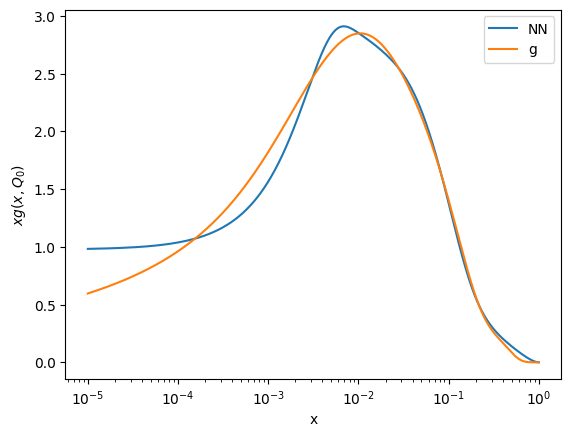


The behaviour at small x is quite wrong and for the last few decades! Despite the fact that we generated half of the data logarithmically at small x precisely to make sure that we had enough data to train this region.

In addition to that, we are seeing that the behaviour of the network is quite flat. This is a common problem when the input data involves different scales and which require some form of preprocessing of the input.

Text(0, 0.5, 'N')

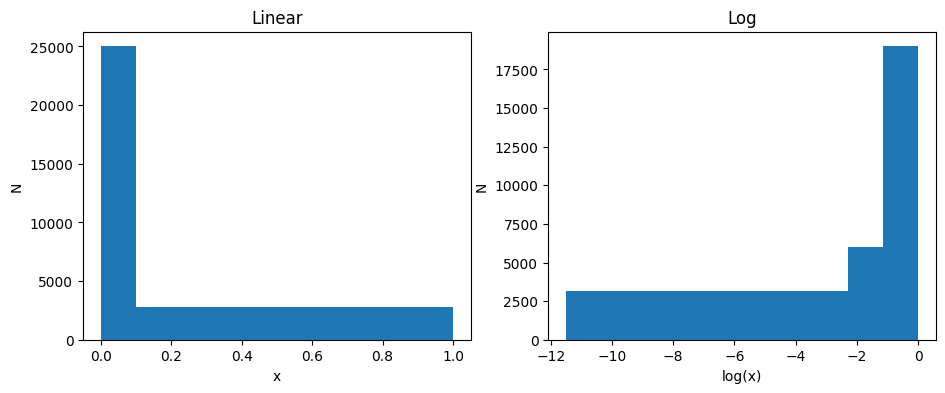

In [3]:
c, b = np.histogram(xgrid)
cl, bl = np.histogram(np.log(xgrid))

plt.subplots(1, 2, figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.title("Linear")
plt.stairs(c, b, fill=True)
plt.xlabel("x")
plt.ylabel("N")
plt.subplot(1, 2, 2)
plt.title("Log")
plt.stairs(cl, bl, fill=True)
plt.xlabel("log(x)")
plt.ylabel("N")

In this particular case since we know the approximate scaling of the input we are going to exploit said knowledge by passing the linear in x and logarithmic in x behaviour as two different dimensions of the input.

1. Create a layer that preprocess the input or does some kind of scaling.

2. Modify the model with your new model, refit and compare!

suggestion:

```python
class InputScaling(tf.keras.layers.Layer):
    """This layer applies a logarithmic scaling to the input and then concatenates it to the actual input
    This layer is dim=1 --> dim=2
    """

    def call(self, x):
        return tf.concat([x, tf.math.log(x)], axis=-1)

# Note that to use this suggestion as the first layer of your model the next layer need to take two inputs! 
```

### 4. Multiflavour fit

In reality the proton is not made only of gluons and indeed all flavours do contribute to it. Let's utilize what we  know to do a fit for all flavours at the same time. At the fitting that we are using only 9 partons are active: u, d, c, s and their antiparticles plus the gluon.

The input is still one dimensional (x) which will become 2-dimensional when we apply the log preprocessing. The output instead is now 9-dimensional.

1. Create a new model with 9 values as the output

2. Train all flavours at the same time

```python
# Prepare the training data
output_basis = [-4, -3, -2, -1, 21, 1, 2, 3, 4]
noutput = len(output_basis)


output_data = np.zeros((len(pdf_grid_all), noutput))

for i, pdf_grid in enumerate(pdf_grid_all):
    for j, pid in enumerate(output_basis):
        output_data[i, j] = pdf_grid[pid]

output_data = np.array(output_data)
output_data.shape
```

### Piquing your interest: hyperparameter selection

In all these examples we have used a Neural Network that is able to give you a good looking PDF amazingly fast. However, when you tackle machine learning problem you will often find that the first few attemps are quite underwhelming.

The secret sauce is in the selection of hyperparameters. Let's imagine that you created a generic function to build your model such as:

```python
def generate_model(..., nlayers=3, units=16, activation="tanh"):
```

In the definition of the function I've set a few defaults which were already tuned to the PDF fit.

- `nlayers` is the number of hidden layers
- `units` is the number of nodes that each one of these layers will have (all the same, for simplicity)
- `activation` activation function at the end of every layer y = activation( Ax + b)

And this is just a subset of the possible hyperparameters! For instance, we are utilizing always the same optimizer with the default values ([tf optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/)). We have also set all hidden layers to be fully-connected dense layers with the same number of units and activation functions for a very simple architecture. But we will see that even with a simple architecture the choice of hyperparameters can have a really big effect on the final results.

Fitting the PDF when we have already access to the LHAPDF grids is particularly easy, buy try to rerun the examples above with particularly crazy inputs! Some examples you can try:

1. A very small number of parameters (very shallow network or layers with not many parameters)
2. Remove complexity from the perceptron, for instance using only `linear` activation functions
3. Use a very large number of parameters, in principle it should be safe... but is it?